In [1]:
# %% [markdown]
# # Section 1 — Dataset Loading
# In this section we import and load the dataset that will be used for handwriting recognition.
# By default we use the IAM Handwriting dataset (Teklia/IAM-line) from Hugging Face.
# For a quick demo, we load only a small slice of the test split.

# %%
# 1) Install dependencies if not already installed
import sys
# Uncomment to install:
# !{sys.executable} -m pip install transformers datasets pillow jiwer torch

# %%
# 2) Imports for dataset loading
import os
from PIL import Image
from datasets import load_dataset

# %%
# 3) Load dataset (IAM handwriting)
# Use a small slice of the test split for a quick demo
DATASET_NAME = "Teklia/IAM-line"
SPLIT = "test[:20]"  # adjust size as needed

print(f"Loading dataset: {DATASET_NAME}, split={SPLIT}")
ds = load_dataset(DATASET_NAME, split=SPLIT)
print(ds)

# Inspect one sample
example = ds[0]
example_image = example["image"]
example_label = example.get("label") or example.get("text") or example.get("transcription")
example_image.show()
print("Ground truth:", example_label)

/Users/aadit/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loading dataset: Teklia/IAM-line, split=test[:20]
Dataset({
    features: ['image', 'text'],
    num_rows: 20
})
Ground truth: assuredness " Bella Bella Marie " ( Parlophone ) , a lively song that changes tempo mid-way .


In [2]:
# %% [markdown]
# # Section 2 — Model Loading and Setup
# In this section we load the pretrained TrOCR model (`microsoft/trocr-base-handwritten`) and processor.
# We configure the model to run only on CPU (suitable for Mac M2).

# %%
# 1) Imports for model and evaluation
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# %%
# 2) Force CPU-only setup
torch.set_num_threads(4)  # limit threads for reproducibility
os.environ['CUDA_VISIBLE_DEVICES'] = ''
device = torch.device('cpu')
print('Running on device:', device)

# %%
# 3) Load pretrained TrOCR model and processor
MODEL_NAME = "microsoft/trocr-base-handwritten"

print("Loading model:", MODEL_NAME)
processor = TrOCRProcessor.from_pretrained(MODEL_NAME)
model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

print("Model loaded successfully and set to evaluation mode.")


Running on device: cpu
Loading model: microsoft/trocr-base-handwritten


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully and set to evaluation mode.


In [3]:
# %% [markdown]
# # Section 2 — Model Loading and Setup
# In this section we load the pretrained TrOCR model (`microsoft/trocr-base-handwritten`) and processor.
# We configure the model to run only on CPU (suitable for Mac M2).

# %%
# 1) Imports for model and evaluation
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# %%
# 2) Force CPU-only setup
torch.set_num_threads(4)  # limit threads for reproducibility
os.environ['CUDA_VISIBLE_DEVICES'] = ''
device = torch.device('cpu')
print('Running on device:', device)

# %%
# 3) Load pretrained TrOCR model and processor
MODEL_NAME = "microsoft/trocr-base-handwritten"

print("Loading model:", MODEL_NAME)
processor = TrOCRProcessor.from_pretrained(MODEL_NAME)
model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

print("Model loaded successfully and set to evaluation mode.")

# %% [markdown]
# # Section 3 — Inference and Evaluation Helpers
# This section provides small, CPU-friendly helper functions for:
# - single-image inference
# - batch inference (iterable)
# - evaluation metrics (WER, CER) using `jiwer`

# %%
# 1) Additional imports for evaluation
import jiwer
from typing import List, Tuple

# Define a stable text normalization pipeline for evaluation
TRANSFORM = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemovePunctuation(),
    jiwer.Strip(),
    jiwer.RemoveMultipleSpaces()
])

# %%
# 2) Single-image inference (CPU-friendly)
def infer_image(processor, model, img: Image.Image, max_length: int = 128, resize_max_width: int = 1024) -> str:
    """Run TrOCR inference on a single PIL Image and return predicted string.
    - Resizes large images to `resize_max_width` to speed up CPU inference.
    - Uses model.generate inside torch.no_grad()."""
    if img.mode != "RGB":
        img = img.convert("RGB")
    if img.width > resize_max_width:
        ratio = resize_max_width / float(img.width)
        new_h = int(img.height * ratio)
        img = img.resize((resize_max_width, new_h))
    inputs = processor(images=img, return_tensors="pt")
    # move to model device (CPU)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        generated_ids = model.generate(inputs["pixel_values"], max_length=max_length)
    preds = processor.batch_decode(generated_ids, skip_special_tokens=True)
    return preds[0].strip()

# %%
# 3) Batch inference helper
from tqdm import tqdm

def infer_batch(processor, model, images: List[Image.Image], max_length: int = 128, resize_max_width: int = 1024, show_progress: bool = True) -> List[str]:
    """Run inference on a list of PIL Images. Returns list of predicted strings."""
    preds = []
    iterator = images if not show_progress else tqdm(images, desc="Inference")
    for img in iterator:
        preds.append(infer_image(processor, model, img, max_length=max_length, resize_max_width=resize_max_width))
    return preds

# %%
# 4) Evaluation helper (WER and CER)
def evaluate_predictions(gts: List[str], preds: List[str]) -> dict:
    """Return WER and CER computed with jiwer using the consistent TRANSFORM."""
    w = jiwer.wer(gts, preds, truth_transform=TRANSFORM, hypothesis_transform=TRANSFORM)
    c = jiwer.cer(gts, preds, truth_transform=TRANSFORM, hypothesis_transform=TRANSFORM)
    return {"WER": w, "CER": c}

# %%
# 5) Quick usage example (paste and run after Sections 1-2):
# imgs = [ex['image'] for ex in ds]
# gts = [ex.get('label') or ex.get('text') or ex.get('transcription') or '' for ex in ds]
# preds = infer_batch(processor, model, imgs, resize_max_width=1024)
# metrics = evaluate_predictions(gts, preds)
# print(metrics)

# End of Section 3


Running on device: cpu
Loading model: microsoft/trocr-base-handwritten


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully and set to evaluation mode.


In [4]:
# %% [markdown]
# # Section 3 — Inference and Evaluation Helpers
# In this section we define helper functions to:
# - Run inference on a single image or a batch of images.
# - Normalize text outputs.
# - Compute evaluation metrics (CER and WER).

# %%
from PIL import Image
import jiwer

# %%
# 1) Inference helper for single image
def infer_image(img: Image.Image, max_length=128, resize_max_width=1024):
    # Ensure RGB format
    if img.mode != "RGB":
        img = img.convert("RGB")
    # Resize for speed if needed
    if img.width > resize_max_width:
        ratio = resize_max_width / float(img.width)
        new_h = int(img.height * ratio)
        img = img.resize((resize_max_width, new_h))
    # Preprocess
    inputs = processor(images=img, return_tensors="pt").to(device)
    # Generate prediction
    with torch.no_grad():
        generated_ids = model.generate(inputs["pixel_values"], max_length=max_length)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

# %%
# 2) Batch inference
def infer_batch(images, max_length=128, resize_max_width=1024):
    preds = []
    for img in images:
        preds.append(infer_image(img, max_length=max_length, resize_max_width=resize_max_width))
    return preds

# %%
# 3) Evaluation helpers (CER/WER)
TRANSFORM = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemovePunctuation(),
    jiwer.Strip(),
    jiwer.RemoveMultipleSpaces()
])

def evaluate(gts, preds):
    return {
        "WER": jiwer.wer(gts, preds, truth_transform=TRANSFORM, hypothesis_transform=TRANSFORM),
        "CER": jiwer.cer(gts, preds, truth_transform=TRANSFORM, hypothesis_transform=TRANSFORM)
    }
# %% [markdown]
# # Section 3 — Inference and Evaluation Helpers
# This section provides small, CPU-friendly helper functions for:
# - single-image inference
# - batch inference (iterable)
# - evaluation metrics (WER, CER) using `jiwer`

# %%
# 1) Additional imports for evaluation
import jiwer
from typing import List, Tuple

# Define a stable text normalization pipeline for evaluation
TRANSFORM = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemovePunctuation(),
    jiwer.Strip(),
    jiwer.RemoveMultipleSpaces()
])

# %%
# 2) Single-image inference (CPU-friendly)
def infer_image(processor, model, img: Image.Image, max_length: int = 128, resize_max_width: int = 1024) -> str:
    """Run TrOCR inference on a single PIL Image and return predicted string.
    - Resizes large images to `resize_max_width` to speed up CPU inference.
    - Uses model.generate inside torch.no_grad()."""
    if img.mode != "RGB":
        img = img.convert("RGB")
    if img.width > resize_max_width:
        ratio = resize_max_width / float(img.width)
        new_h = int(img.height * ratio)
        img = img.resize((resize_max_width, new_h))
    inputs = processor(images=img, return_tensors="pt")
    # move to model device (CPU)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        generated_ids = model.generate(inputs["pixel_values"], max_length=max_length)
    preds = processor.batch_decode(generated_ids, skip_special_tokens=True)
    return preds[0].strip()

# %%
# 3) Batch inference helper
from tqdm import tqdm

def infer_batch(processor, model, images: List[Image.Image], max_length: int = 128, resize_max_width: int = 1024, show_progress: bool = True) -> List[str]:
    """Run inference on a list of PIL Images. Returns list of predicted strings."""
    preds = []
    iterator = images if not show_progress else tqdm(images, desc="Inference")
    for img in iterator:
        preds.append(infer_image(processor, model, img, max_length=max_length, resize_max_width=resize_max_width))
    return preds

# %%
# 4) Evaluation helper (WER and CER)
def evaluate_predictions(gts: List[str], preds: List[str]) -> dict:
    """Return WER and CER computed with jiwer using the consistent TRANSFORM."""
    w = jiwer.wer(gts, preds, truth_transform=TRANSFORM, hypothesis_transform=TRANSFORM)
    c = jiwer.cer(gts, preds, truth_transform=TRANSFORM, hypothesis_transform=TRANSFORM)
    return {"WER": w, "CER": c}

# %%
# 5) Quick usage example (paste and run after Sections 1-2):
# imgs = [ex['image'] for ex in ds]
# gts = [ex.get('label') or ex.get('text') or ex.get('transcription') or '' for ex in ds]
# preds = infer_batch(processor, model, imgs, resize_max_width=1024)
# metrics = evaluate_predictions(gts, preds)
# print(metrics)

# End of Section 3


# %% [markdown]
# # Section 4 — Preprocessing & Visualization
# This section contains lightweight preprocessing utilities (autocontrast, grayscale, threshold, invert, padding)
# and small visualization helpers to inspect samples and predictions. All operations are CPU-friendly.

# %%
# 1) Additional imports for visualization and basic image ops
from PIL import ImageOps, ImageFilter
import matplotlib.pyplot as plt

# %%
# 2) Preprocessing functions

def preprocess_image(img: Image.Image, do_grayscale: bool = False, autocontrast: bool = False,
                     invert: bool = False, threshold: int = None, pad: int = 0) -> Image.Image:
    """Apply simple, fast preprocessing to a PIL Image and return a new PIL Image.
    - do_grayscale: convert to L then back to RGB
    - autocontrast: apply ImageOps.autocontrast
    - invert: invert colors (useful if background is dark)
    - threshold: if set (0-255), convert to binary using given threshold
    - pad: add white padding around image (pixels)
    """
    img = img.copy()
    if do_grayscale:
        img = ImageOps.grayscale(img).convert("RGB")
    if autocontrast:
        img = ImageOps.autocontrast(img)
    if invert:
        img = ImageOps.invert(img.convert("RGB"))
    if threshold is not None:
        # Convert to L, apply threshold, return RGB
        l = img.convert("L")
        l = l.point(lambda p: 255 if p > threshold else 0)
        img = l.convert("RGB")
    if pad and pad > 0:
        w,h = img.size
        new = Image.new("RGB", (w+pad*2, h+pad*2), color=(255,255,255))
        new.paste(img, (pad,pad))
        img = new
    return img

# %%
# 3) Batch preprocessing helper

def preprocess_batch(samples, **kwargs):
    """samples: list of dicts with 'image' and optional 'transcription'. Returns new list of dicts."""
    out = []
    for ex in samples:
        img = ex['image']
        gt = ex.get('transcription') or ex.get('label') or ex.get('text') or ex.get('transcription','')
        img2 = preprocess_image(img, **kwargs)
        out.append({'image': img2, 'transcription': gt})
    return out

# %%
# 4) Visualization helpers (display grid of images with GT captions)

def show_samples_grid(samples, ncols=2, max_examples=6, figsize=(10,8), title_prefix=''):
    """Display up to max_examples images in a grid using matplotlib. Each image shows its GT if available."""
    n = min(max_examples, len(samples))
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(nrows, ncols, i+1)
        img = samples[i]['image']
        plt.imshow(img)
        gt = samples[i].get('transcription') or samples[i].get('label') or samples[i].get('text') or ''
        plt.title(f"{title_prefix}GT: {gt[:80]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# %%
# 5) Small example: show raw and preprocessed versions side-by-side for first few samples
# Usage (run after Sections 1-3):
# raw_samples = [{'image': ex['image'], 'transcription': ex.get('label') or ex.get('text') or ex.get('transcription','')} for ex in ds]
# pre = preprocess_batch(raw_samples, autocontrast=True, do_grayscale=False, threshold=None, pad=4)
# show_samples_grid(raw_samples, ncols=2, max_examples=4, title_prefix='Raw: ')
# show_samples_grid(pre, ncols=2, max_examples=4, title_prefix='Pre: ')

# End of Section 4


Using pool of 20 samples for ablation experiments.

Ablation: resize_width=1024, n_samples=20


Inference: 100%|████████████████████████████████| 20/20 [00:37<00:00,  1.88s/it]


Result: {'resize_width': 1024, 'n_samples': 20, 'time_s_total': 37.677, 'time_s_per_sample': 1.884, 'WER': 0.148, 'CER': 0.0449}

Ablation: resize_width=800, n_samples=20


Inference: 100%|████████████████████████████████| 20/20 [00:36<00:00,  1.85s/it]


Result: {'resize_width': 800, 'n_samples': 20, 'time_s_total': 36.926, 'time_s_per_sample': 1.846, 'WER': 0.1345, 'CER': 0.0389}

Ablation: resize_width=640, n_samples=20


Inference: 100%|████████████████████████████████| 20/20 [00:36<00:00,  1.81s/it]


Result: {'resize_width': 640, 'n_samples': 20, 'time_s_total': 36.133, 'time_s_per_sample': 1.807, 'WER': 0.148, 'CER': 0.0415}

Ablation: resize_width=480, n_samples=20


Inference: 100%|████████████████████████████████| 20/20 [00:35<00:00,  1.78s/it]


Result: {'resize_width': 480, 'n_samples': 20, 'time_s_total': 35.672, 'time_s_per_sample': 1.784, 'WER': 0.1614, 'CER': 0.0536}

Saved ablation results to ablation_results.csv

Ablation summary:
    resize_width  n_samples  time_s_total  time_s_per_sample     WER     CER
0          1024         20        37.677              1.884  0.1480  0.0449
1           800         20        36.926              1.846  0.1345  0.0389
2           640         20        36.133              1.807  0.1480  0.0415
3           480         20        35.672              1.784  0.1614  0.0536


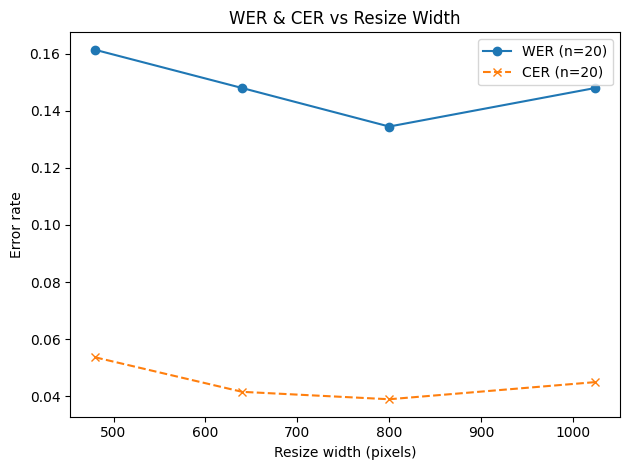

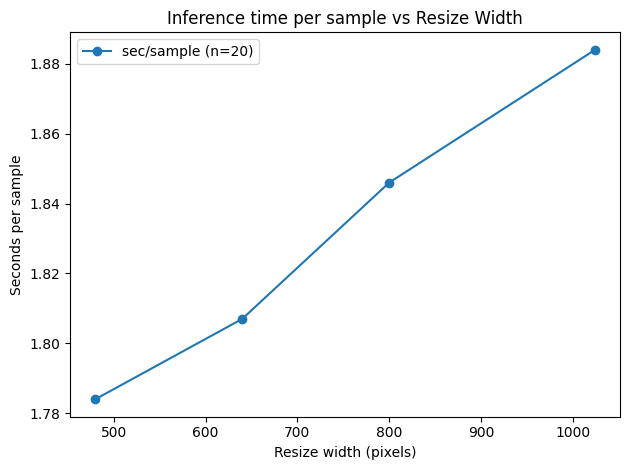

In [6]:
# %% 
# Section 6 — Extended Evaluation & Ablations
# Run ablations to compare accuracy (WER/CER) vs speed (sec/sample) across resize widths and sample sizes.
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from itertools import product

def run_ablation_experiments(resize_widths=[1024, 800, 640, 480], sample_limits=[20, 50], max_samples_overall=200):
    """
    resize_widths: list of widths to resize images to before inference
    sample_limits: list of sample sizes to test (use small numbers for CPU)
    max_samples_overall: upper bound to avoid extremely long runs on CPU
    """
    results = []
    # Prepare a base pool of images (use ds loaded in Section 1)
    base_pool = [ {'image': ex['image'], 'transcription': ex.get('label') or ex.get('text') or ex.get('transcription','')} for ex in ds ]
    pool_n = len(base_pool)
    if pool_n == 0:
        raise RuntimeError("No samples available in `ds`. Run Section 1 to load data.")
    # limit overall
    pool = base_pool[:min(pool_n, max_samples_overall)]
    print(f"Using pool of {len(pool)} samples for ablation experiments.")
    for sample_limit, resize_w in product(sample_limits, resize_widths):
        n = min(sample_limit, len(pool))
        subset = pool[:n]
        imgs = [ex['image'] for ex in subset]
        gts = [ex['transcription'] for ex in subset]
        print(f"\nAblation: resize_width={resize_w}, n_samples={n}")
        t0 = time()
        preds = infer_batch(processor, model, imgs, resize_max_width=resize_w, show_progress=True)
        t1 = time()
        elapsed = t1 - t0
        time_per_sample = elapsed / max(1, n)
        metrics = evaluate_predictions(gts, preds)
        row = {
            'resize_width': resize_w,
            'n_samples': n,
            'time_s_total': round(elapsed, 3),
            'time_s_per_sample': round(time_per_sample, 3),
            'WER': round(metrics['WER'], 4),
            'CER': round(metrics['CER'], 4)
        }
        print("Result:", row)
        results.append(row)
    df = pd.DataFrame(results)
    # Save results
    out_csv = 'ablation_results.csv'
    df.to_csv(out_csv, index=False)
    print(f"\nSaved ablation results to {out_csv}")
    return df

# Plotting helper (two plots)
def plot_ablation(df, metric_cols=['WER','CER'], x_col='resize_width'):
    # Ensure numeric sorting on x-axis
    df_plot = df.copy()
    df_plot[x_col] = pd.to_numeric(df_plot[x_col], errors='coerce')
    df_plot = df_plot.sort_values(x_col)
    # Plot WER and CER vs resize width (multiple sample sizes will be separate markers)
    fig, ax = plt.subplots()
    for n in sorted(df_plot['n_samples'].unique()):
        sub = df_plot[df_plot['n_samples']==n]
        ax.plot(sub[x_col], sub['WER'], marker='o', label=f'WER (n={n})')
        ax.plot(sub[x_col], sub['CER'], marker='x', linestyle='--', label=f'CER (n={n})')
    ax.set_xlabel('Resize width (pixels)')
    ax.set_ylabel('Error rate')
    ax.set_title('WER & CER vs Resize Width')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Time per sample plot
    fig2, ax2 = plt.subplots()
    for n in sorted(df_plot['n_samples'].unique()):
        sub = df_plot[df_plot['n_samples']==n]
        ax2.plot(sub[x_col], sub['time_s_per_sample'], marker='o', label=f'sec/sample (n={n})')
    ax2.set_xlabel('Resize width (pixels)')
    ax2.set_ylabel('Seconds per sample')
    ax2.set_title('Inference time per sample vs Resize Width')
    ax2.legend()
    plt.tight_layout()
    plt.show()

# Default ablation run (safe defaults for CPU)
# You can change resize_widths and sample_limits as desired.
ablation_df = run_ablation_experiments(resize_widths=[1024, 800, 640, 480], sample_limits=[20], max_samples_overall=200)
print("\nAblation summary:\n", ablation_df)
plot_ablation(ablation_df)


In [15]:
# ==== CRNN retrain: end-to-end, single cell (dataset + model + training) ====
# This cell defines OCRDataset, collate_ctc, SmallCRNN, and runs your whole pipeline.
# It uses IAM-line via datasets; if offline, it falls back to any existing `raw_samples`.
import os, random, math, csv, string
from collections import Counter
import numpy as np
from PIL import Image, ImageOps
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ---------------- Character set + indices ----------------
try:
    CHAR_LIST
except NameError:
    # space + a-z + digits + common punctuation
    CHAR_LIST = list(" " + string.ascii_lowercase + string.digits + string.punctuation)

CHAR_TO_IDX = {c: i for i, c in enumerate(CHAR_LIST)}
IDX_TO_CHAR = {i: c for c, i in CHAR_TO_IDX.items()}
BLANK_IDX = len(CHAR_LIST)  # CTC blank

def text_to_indices(s: str):
    s = (s or "").lower()
    return [CHAR_TO_IDX[c] for c in s if c in CHAR_TO_IDX]

# ---------------- Minimal CTC decoder fallback (greedy) ----------------
def _greedy_ctc_decode(logits, **kwargs):
    # logits: T x B x C
    logp = torch.log_softmax(logits, dim=2)
    best = torch.argmax(logp, dim=2)  # T x B
    T, B = best.size()
    outs = []
    for b in range(B):
        prev = -1
        seq = []
        for t in range(T):
            p = int(best[t, b])
            if p != BLANK_IDX and p != prev:
                seq.append(IDX_TO_CHAR.get(p, ""))
            prev = p
        outs.append("".join(seq))
    return outs

try:
    beam_ctc_decode
except NameError:
    beam_ctc_decode = _greedy_ctc_decode

# ---------------- Hyperparams ----------------
NEW_SLICE = 500         # how many dataset lines to use (increase to 1000+ if you can)
TRAIN_RATIO = 0.9       # train/val split
EPOCHS = 12             # increase if you have time
BATCH_SIZE = 8          # increase if memory allows
NH = 256                # RNN hidden size (bigger model)
BEAM_WIDTH = 7
IMG_H, IMG_W = 32, 256
SAVE_DIR = "crnn_retrain_ckpt"

print("Config:", {"NEW_SLICE": NEW_SLICE, "EPOCHS": EPOCHS, "NH": NH, "BATCH_SIZE": BATCH_SIZE})

# ---------------- Dataset & Collate ----------------
class OCRDataset(Dataset):
    """
    Expects a list of dicts: {'image': PIL.Image (RGB/gray), 'transcription': str}
    Returns: (image_tensor[Bx1xH x W], target_indices[List[int]])
    """
    def __init__(self, samples, img_h=32, img_w=256, augment=False):
        self.samples = samples
        self.img_h = img_h
        self.img_w = img_w
        self.augment = augment

    def __len__(self):
        return len(self.samples)

    def _augment_pil(self, im: Image.Image) -> Image.Image:
        # lightweight, safe augment
        if random.random() < 0.25:
            angle = random.uniform(-2.0, 2.0)
            im = im.rotate(angle, resample=Image.BILINEAR, expand=False, fillcolor=255)
        if random.random() < 0.15:
            shift = random.uniform(-0.02, 0.02) * im.width
            im = ImageOps.expand(im, border=(int(abs(shift)),0,0,0), fill=255) if shift>0 else ImageOps.crop(im, (int(abs(shift)),0,0,0))
            im = im.resize((self.img_w, self.img_h), Image.BILINEAR)
        return im

    def _pil_to_tensor(self, im: Image.Image) -> torch.Tensor:
        if im.mode != "L":
            im = im.convert("L")  # grayscale
        im = im.resize((self.img_w, self.img_h), Image.BILINEAR)
        arr = np.array(im, dtype=np.float32) / 255.0
        arr = (arr - 0.5) / 0.5  # normalize ~ N(0,1)
        t = torch.from_numpy(arr)[None, ...]  # 1 x H x W
        return t

    def __getitem__(self, idx):
        ex = self.samples[idx]
        im = ex['image']
        if not isinstance(im, Image.Image):
            # defensively convert if needed (e.g., datasets returning arrays)
            im = Image.fromarray(np.array(im))
        if self.augment:
            im = self._augment_pil(im)
        tgt = ex.get('transcription') or ""
        return self._pil_to_tensor(im), torch.tensor(text_to_indices(tgt), dtype=torch.long)

def collate_ctc(batch):
    """
    batch: list of (img_tensor[1,H,W], target_indices[Tensor(L_i)])
    returns:
      imgs: Tensor[B,1,H,W]
      targets_concat: Tensor[sum(L_i)]
      target_lengths: Tensor[B]
    """
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    lengths = torch.tensor([t.size(0) for t in targets], dtype=torch.long)
    if sum(lengths).item() == 0:
        targets_concat = torch.zeros((0,), dtype=torch.long)
    else:
        targets_concat = torch.cat(targets, dim=0)
    return imgs, targets_concat, lengths

# ---------------- Compact CRNN model ----------------
class SmallCRNN(nn.Module):
    """
    CNN -> temporal pooling (mean over height) -> BiLSTM -> logits (T x B x nclass)
    Designed to be simple and robust to input sizes.
    """
    def __init__(self, imgH=32, nc=1, nclass=100, nh=256):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(nc, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),  # H/2, W/2

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),  # H/4, W/4

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.rnn = nn.LSTM(input_size=512, hidden_size=nh, num_layers=2,
                           bidirectional=True, batch_first=False, dropout=0.1)
        self.fc = nn.Linear(nh*2, nclass)

    def forward(self, x):
        # x: B x 1 x H x W
        feat = self.cnn(x)                # B x C x H' x W'
        feat = feat.mean(dim=2)           # average over height -> B x C x W'
        feat = feat.permute(2, 0, 1)      # W' x B x C (T x B x C)
        out, _ = self.rnn(feat)           # T x B x 2*nh
        logits = self.fc(out)             # T x B x nclass
        return logits

# ---------------- 1) Inspect function ----------------
def inspect_targets(samples, char_set=None):
    if char_set is None:
        char_set = set(CHAR_LIST)
    empty = []
    unknown_char_counter = Counter()
    for i, s in enumerate(samples):
        txt = (s.get('transcription') or "")
        if not txt or txt.strip() == "":
            empty.append(i); continue
        for ch in set(str(txt).lower()):
            if ch not in char_set:
                unknown_char_counter[ch] += 1
    print(f"Total samples: {len(samples)}")
    print("Empty target count:", len(empty), "indices (first 10):", empty[:10])
    print("Top unknown characters (if any):", unknown_char_counter.most_common(10))
    return empty, unknown_char_counter

if 'train_pool' in globals():
    print("Existing train_pool size:", len(train_pool))
    inspect_targets(train_pool)

# ---------------- 2) Load a larger slice (HF) or fallback ----------------
try:
    from datasets import load_dataset
    print("Attempting to reload a larger slice from Hugging Face (this will download if not cached)...")
    ds_large = load_dataset("Teklia/IAM-line", split=f"test[:{NEW_SLICE}]")
    print("Loaded ds_large length:", len(ds_large))
    raw = []
    for ex in ds_large:
        gt = ex.get('label') or ex.get('text') or ex.get('transcription') or ""
        raw.append({'image': ex['image'].convert('RGB'), 'transcription': gt})
    labeled = [r for r in raw if (r['transcription'] or "").strip() != ""]
    print("Labeled lines in slice:", len(labeled))
except Exception as e:
    print("Could not fetch larger HF split (error):", e)
    if 'raw_samples' in globals():
        labeled = [s for s in raw_samples if (s['transcription'] or "").strip() != ""]
        print("Using existing raw_samples labeled count:", len(labeled))
    else:
        raise RuntimeError("No dataset available to expand. Ensure internet or provide local images.")

# ---------------- 3) Inspect & clean ----------------
empty_idx, unknown_chars = inspect_targets(labeled)
if len(empty_idx) > 0:
    print("Warning: there were empty transcripts in the newly loaded data. They will be dropped.")
    labeled = [l for i, l in enumerate(labeled) if i not in empty_idx]

# ---------------- 4) Split ----------------
random.seed(42)
random.shuffle(labeled)
split_pt = int(len(labeled) * TRAIN_RATIO)
train_pool = labeled[:split_pt]
val_pool = labeled[split_pt: split_pt + 1000]  # cap val size
print("Final pool sizes -> train:", len(train_pool), "val:", len(val_pool))
if len(train_pool) < 50:
    print("Warning: train size still small (<50). Results will be poor. Increase NEW_SLICE if possible.")

# ---------------- 5) Datasets + loaders + model ----------------
train_ds = OCRDataset(train_pool, img_h=IMG_H, img_w=IMG_W, augment=True)
val_ds   = OCRDataset(val_pool,   img_h=IMG_H, img_w=IMG_W, augment=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_ctc, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_ctc, drop_last=False)

crnn = SmallCRNN(imgH=IMG_H, nc=1, nclass=len(CHAR_LIST) + 1, nh=NH)  # +1 for CTC blank
print("CRNN re-created with NH=", NH, "Params:", sum(p.numel() for p in crnn.parameters()))

# --- Hotfix: make the greedy CTC fallback accept beam_width (and any kwargs) ---
import inspect

# Re-define greedy decoder with flexible signature
def _greedy_ctc_decode(logits, **kwargs):
    # logits: T x B x C
    import torch
    logp = torch.log_softmax(logits, dim=2)
    best = torch.argmax(logp, dim=2)  # T x B
    T, B = best.size()
    outs = []
    for b in range(B):
        prev = -1
        seq = []
        for t in range(T):
            p = int(best[t, b])
            if p != BLANK_IDX and p != prev:
                seq.append(IDX_TO_CHAR.get(p, ""))
            prev = p
        outs.append("".join(seq))
    return outs

# If there's no real beam decoder (or it doesn't accept beam_width), wrap it to ignore kwargs.
if 'beam_ctc_decode' not in globals():
    beam_ctc_decode = _greedy_ctc_decode
else:
    sig = None
    try:
        sig = inspect.signature(beam_ctc_decode)
    except (TypeError, ValueError):
        pass
    if not sig or ('beam_width' not in sig.parameters):
        _orig_beam = beam_ctc_decode
        def beam_ctc_decode(logits, beam_width=None, **kwargs):
            # Fall back to original function, ignoring extra args
            return _orig_beam(logits)


# ---------------- 6) Train loop (robust) ----------------
def train_crnn_improved_robust(model, train_loader, val_dataset=None, epochs=10, lr=1e-3,
                               device=torch.device('cpu'), grad_clip=5.0, beam_width=7, save_dir="crnn_retrain_ckpt"):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    ctc = nn.CTCLoss(blank=BLANK_IDX, zero_infinity=True)
    best_val_cer = math.inf

    for ep in range(1, epochs + 1):
        model.train()
        tot_loss = 0.0
        n_batches = 0
        try:
            from tqdm import tqdm
            iterator = tqdm(train_loader, desc=f"Train Ep {ep}/{epochs}")
        except Exception:
            iterator = train_loader

        for imgs, targets_concat, target_lengths in iterator:
            imgs = imgs.to(device)
            targets_concat = targets_concat.to(device)
            target_lengths = target_lengths.to(device)

            logits = model(imgs)                        # T x B x C
            Tt, B, C = logits.size()
            input_lengths = torch.full((B,), Tt, dtype=torch.long, device=device)
            logp = torch.log_softmax(logits, dim=2)
            loss = ctc(logp, targets_concat, input_lengths, target_lengths)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            tot_loss += loss.item()
            n_batches += 1

        avg_loss = tot_loss / max(1, n_batches)
        print(f"Epoch {ep} avg loss: {avg_loss:.4f}")

        # ---- Validation ----
        if val_dataset is not None:
            model.eval()
            all_preds, all_gts = [], []
            with torch.no_grad():
                for imgs, targets_concat, target_lengths in DataLoader(
                        val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_ctc):
                    imgs = imgs.to(device)
                    logits = model(imgs)
                    preds = beam_ctc_decode(logits, beam_width=beam_width)
                    all_preds.extend(preds)

                    idx = 0
                    tcpu = targets_concat.cpu().numpy() if isinstance(targets_concat, torch.Tensor) else targets_concat
                    for l in target_lengths:
                        l = int(l)
                        seq = tcpu[idx:idx + l]
                        gt_str = ''.join([IDX_TO_CHAR.get(int(i), '') for i in seq])
                        all_gts.append(gt_str)
                        idx += l

            # compute metrics
            try:
                import jiwer
                TRANS = jiwer.Compose([jiwer.ToLowerCase(), jiwer.RemovePunctuation(), jiwer.Strip(), jiwer.RemoveMultipleSpaces()])
                g_norm = [TRANS(s) for s in all_gts]
                p_norm = [TRANS(s) for s in all_preds]
                metrics = {'WER': jiwer.wer(g_norm, p_norm), 'CER': jiwer.cer(g_norm, p_norm)}
            except Exception:
                # naive CER proxy if jiwer is missing
                def _cer(a, b):
                    if len(a) == 0 and len(b) == 0: return 0.0
                    dp = np.zeros((len(a)+1, len(b)+1), dtype=np.int32)
                    for i in range(len(a)+1): dp[i,0] = i
                    for j in range(len(b)+1): dp[0,j] = j
                    for i in range(1, len(a)+1):
                        for j in range(1, len(b)+1):
                            cost = 0 if a[i-1]==b[j-1] else 1
                            dp[i,j] = min(dp[i-1,j]+1, dp[i,j-1]+1, dp[i-1,j-1]+cost)
                    return dp[len(a), len(b)] / max(1, len(a))
                cer_vals = [_cer(g, p) for g, p in zip(all_gts, all_preds)]
                metrics = {'CER': float(sum(cer_vals) / max(1, len(cer_vals)))}

            val_cer = metrics.get('CER', math.inf)
            print(f"Validation metrics epoch {ep}:", metrics)

            if val_cer < best_val_cer:
                best_val_cer = val_cer
                ckpt = os.path.join(save_dir, f"crnn_best_ep{ep}_cer{val_cer:.4f}.pt")
                torch.save(model.state_dict(), ckpt)
                print("Saved", ckpt)

            scheduler.step(val_cer)

    print("Training finished.")

# ---------------- 7) Train ----------------
train_crnn_improved_robust(
    crnn, train_loader, val_dataset=val_ds, epochs=EPOCHS, lr=1e-3,
    device=torch.device('cpu'), grad_clip=5.0, beam_width=BEAM_WIDTH, save_dir=SAVE_DIR
)

# ---------------- 8) Final eval + CSV (vs optional TrOCR preds in `preds`) ----------------
crnn.eval()
all_crnn_preds, all_gts = [], []
with torch.no_grad():
    for imgs, targets_concat, target_lengths in DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_ctc):
        imgs = imgs.to('cpu')
        logits = crnn(imgs)
        preds_batch = beam_ctc_decode(logits, beam_width=BEAM_WIDTH)
        all_crnn_preds.extend(preds_batch)
        idx = 0
        tcpu = targets_concat.cpu().numpy() if isinstance(targets_concat, torch.Tensor) else targets_concat
        for l in target_lengths:
            l = int(l)
            seq = tcpu[idx:idx + l]
            gt_str = ''.join([IDX_TO_CHAR.get(int(i), '') for i in seq])
            all_gts.append(gt_str)
            idx += l

try:
    import jiwer
    TRANS = jiwer.Compose([jiwer.ToLowerCase(), jiwer.RemovePunctuation(), jiwer.Strip(), jiwer.RemoveMultipleSpaces()])
    g_norm = [TRANS(s) for s in all_gts]
    p_norm = [TRANS(s) for s in all_crnn_preds]
    print("Final CRNN metrics:", {'WER': jiwer.wer(g_norm, p_norm), 'CER': jiwer.cer(g_norm, p_norm)})
except Exception:
    print("Final CRNN preds length:", len(all_crnn_preds), "GT length:", len(all_gts))

# CSV with optional TrOCR preds if available in `preds`
trocr_preds = preds if ('preds' in globals() and isinstance(preds, list)) else []
with open("crnn_retrain_vs_trocr.csv", "w", newline='', encoding='utf-8') as f:
    w = csv.writer(f)
    w.writerow(['gt', 'crnn_beam', 'trocr_pred'])
    for i, gt in enumerate(all_gts):
        tr = trocr_preds[i] if i < len(trocr_preds) else ""
        cr = all_crnn_preds[i] if i < len(all_crnn_preds) else ""
        w.writerow([gt, cr, tr])
print("Saved crnn_retrain_vs_trocr.csv")


Config: {'NEW_SLICE': 500, 'EPOCHS': 12, 'NH': 256, 'BATCH_SIZE': 8}
Existing train_pool size: 450
Total samples: 450
Empty target count: 0 indices (first 10): []
Top unknown characters (if any): []
Attempting to reload a larger slice from Hugging Face (this will download if not cached)...
Loaded ds_large length: 500
Labeled lines in slice: 500
Total samples: 500
Empty target count: 0 indices (first 10): []
Top unknown characters (if any): []
Final pool sizes -> train: 450 val: 50
CRNN re-created with NH= 256 Params: 5330758


Train Ep 1/12: 100%|████████████████████████████| 57/57 [00:10<00:00,  5.62it/s]


Epoch 1 avg loss: 3.2115
Validation metrics epoch 1: {'WER': 1.0, 'CER': 1.0}
Saved crnn_retrain_ckpt/crnn_best_ep1_cer1.0000.pt


Train Ep 2/12: 100%|████████████████████████████| 57/57 [00:10<00:00,  5.65it/s]


Epoch 2 avg loss: 2.8461
Validation metrics epoch 2: {'WER': 1.0, 'CER': 1.0}


Train Ep 3/12: 100%|████████████████████████████| 57/57 [00:10<00:00,  5.64it/s]


Epoch 3 avg loss: 2.8157
Validation metrics epoch 3: {'WER': 1.0, 'CER': 0.9786324786324786}
Saved crnn_retrain_ckpt/crnn_best_ep3_cer0.9786.pt


Train Ep 4/12: 100%|████████████████████████████| 57/57 [00:09<00:00,  5.71it/s]


Epoch 4 avg loss: 2.7877
Validation metrics epoch 4: {'WER': 1.0, 'CER': 0.9615384615384616}
Saved crnn_retrain_ckpt/crnn_best_ep4_cer0.9615.pt


Train Ep 5/12: 100%|████████████████████████████| 57/57 [00:10<00:00,  5.59it/s]


Epoch 5 avg loss: 2.7029
Validation metrics epoch 5: {'WER': 1.0, 'CER': 0.97340930674264}


Train Ep 6/12: 100%|████████████████████████████| 57/57 [00:09<00:00,  5.74it/s]


Epoch 6 avg loss: 2.5493
Validation metrics epoch 6: {'WER': 1.0, 'CER': 0.9824311490978158}


Train Ep 7/12: 100%|████████████████████████████| 57/57 [00:09<00:00,  5.72it/s]


Epoch 7 avg loss: 2.4642
Validation metrics epoch 7: {'WER': 1.0, 'CER': 0.9776828110161444}


Train Ep 8/12: 100%|████████████████████████████| 57/57 [00:10<00:00,  5.68it/s]


Epoch 8 avg loss: 2.3318
Validation metrics epoch 8: {'WER': 0.9622166246851386, 'CER': 0.7198480531813866}
Saved crnn_retrain_ckpt/crnn_best_ep8_cer0.7198.pt


Train Ep 9/12: 100%|████████████████████████████| 57/57 [00:10<00:00,  5.68it/s]


Epoch 9 avg loss: 2.2756
Validation metrics epoch 9: {'WER': 1.0302267002518892, 'CER': 0.6766381766381766}
Saved crnn_retrain_ckpt/crnn_best_ep9_cer0.6766.pt


Train Ep 10/12: 100%|███████████████████████████| 57/57 [00:10<00:00,  5.62it/s]


Epoch 10 avg loss: 2.1728
Validation metrics epoch 10: {'WER': 0.9571788413098237, 'CER': 0.6828110161443495}


Train Ep 11/12: 100%|███████████████████████████| 57/57 [00:10<00:00,  5.68it/s]


Epoch 11 avg loss: 2.1337
Validation metrics epoch 11: {'WER': 1.0277078085642317, 'CER': 0.7711301044634378}


Train Ep 12/12: 100%|███████████████████████████| 57/57 [00:09<00:00,  5.73it/s]


Epoch 12 avg loss: 2.0902
Validation metrics epoch 12: {'WER': 0.9773299748110831, 'CER': 0.8660968660968661}
Training finished.
Final CRNN metrics: {'WER': 0.9773299748110831, 'CER': 0.8660968660968661}
Saved crnn_retrain_vs_trocr.csv


In [30]:
# %% [markdown]
# ## Section 8 — NLP Post-Correction (Norvig-style) + Confusion Analysis
# Builds an in-domain vocabulary from ground-truths, applies a lightweight spell-corrector
# to OCR outputs, compares metrics before/after, and prints common confusions.

# %%
import re, random
from collections import Counter, defaultdict
import csv

# -------------------------
# 1) Collect corpus from available ground-truths
# -------------------------
corpus_texts = []
# Prefer the HF dataset 'ds' if present, otherwise fall back to raw_samples / val_gts etc.
try:
    for ex in ds:
        gt = ex.get('label') or ex.get('text') or ex.get('transcription') or ""
        if gt:
            corpus_texts.append(gt)
except Exception:
    # fallback options
    if 'raw_samples' in globals():
        for ex in raw_samples:
            corpus_texts.append(ex.get('transcription',''))
    if 'val_gts' in globals():
        corpus_texts.extend([t for t in val_gts if t])
    if 'gts' in globals():
        corpus_texts.extend([t for t in gts if t])

print(f"Collected {len(corpus_texts)} transcripts for vocabulary building (may include duplicates).")

# -------------------------
# 2) Build word frequency / vocab
# -------------------------
def words(text):
    return re.findall(r"[a-zA-Z0-9']+", text.lower())

WORD_COUNTS = Counter()
for t in corpus_texts:
    WORD_COUNTS.update(words(t))

VOCAB = set(WORD_COUNTS.keys())
print("Vocabulary size (unique words):", len(VOCAB))

# -------------------------
# 3) Norvig-style corrector (lightweight)
# -------------------------
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789'"

def edits1(word):
    splits = [(word[:i], word[i:]) for i in range(len(word)+1)]
    deletes = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    replaces = [L + c + (R[1:] if len(R)>0 else '') for L,R in splits if R for c in alphabet]
    inserts = [L + c + R for L,R in splits for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def known(words_iter):
    return set(w for w in words_iter if w in VOCAB)

def candidates(word):
    if word in VOCAB:
        return [word]
    c1 = known(edits1(word))
    if c1:
        return sorted(c1, key=lambda w: -WORD_COUNTS[w])
    # fallback: return original word
    return [word]

def correct_word(word):
    if not re.match(r"^[A-Za-z']+$", word):
        return word
    w = word.lower()
    cand = candidates(w)
    return cand[0] if cand else w

def correct_sentence(sentence):
    tokens = re.findall(r"[A-Za-z0-9']+|[^A-Za-z0-9'\s]+|\s+", sentence)
    out = []
    for tok in tokens:
        if re.match(r"[A-Za-z0-9']+", tok):
            corr = correct_word(tok)
            # preserve Title case
            if tok.istitle():
                corr = corr.capitalize()
            out.append(corr)
        else:
            out.append(tok)
    return ''.join(out)

# -------------------------
# 4) Apply correction to OCR outputs
# -------------------------
# Ensure we have preds and gts from TrOCR baseline and optionally crnn_preds from the CRNN
if 'preds' not in globals():
    print("Warning: `preds` (TrOCR predictions) not found. Run TrOCR inference (Section 5) first.")
if 'gts' not in globals():
    print("Warning: `gts` (ground-truths) not found. Run Section 1/5 to populate ground-truths.")

# Correct TrOCR preds if available
corrected_preds = None
if 'preds' in globals():
    corrected_preds = [correct_sentence(p) for p in preds]

# Correct CRNN preds if available
corrected_crnn_preds = None
if 'crnn_preds' in globals():
    corrected_crnn_preds = [correct_sentence(p) for p in crnn_preds]

# -------------------------
# 5) Show before/after examples (TrOCR)
# -------------------------
if corrected_preds:
    print("\nTrOCR: Before -> After (first 10 examples):")
    for i,(gt,p,cp) in enumerate(zip(gts, preds, corrected_preds)):
        if i >= 10: break
        print(f"\nSample {i+1}")
        print("GT :", gt)
        print("OCR:", p)
        print("COR:", cp)

# -------------------------
# 6) Re-evaluate metrics before/after
# -------------------------
# Use evaluate_predictions (already defined earlier)
results = {}
if 'gts' in globals() and 'preds' in globals():
    results['trocr_before'] = evaluate_predictions(gts, preds)
    if corrected_preds:
        results['trocr_after'] = evaluate_predictions(gts, corrected_preds)

if 'val_gts' in globals() and 'crnn_preds' in globals():
    results['crnn_before'] = evaluate_predictions(val_gts, crnn_preds)
    if corrected_crnn_preds:
        results['crnn_after'] = evaluate_predictions(val_gts, corrected_crnn_preds)

def _upper_only(m):
    """Return a dict with only uppercase 'WER' and 'CER' keys (no lowercase)."""
    WER = float(m.get('WER', m.get('wer', 0.0)))
    CER = float(m.get('CER', m.get('cer', 0.0)))
    return {'WER': WER, 'CER': CER}

print("\nMetrics summary (before -> after where available):")

print("\nMetrics summary (before -> after where available):")

# -- helper to keep only uppercase keys --
def _upper_only(m):
    WER = float(m.get('WER', m.get('wer', 0.0)))
    CER = float(m.get('CER', m.get('cer', 0.0)))
    return {'WER': WER, 'CER': CER}

# --- Print TrOCR lines (uppercase-only) ---
for name in ['trocr_before', 'trocr_after']:
    if name in results:
        print(name, ":", _upper_only(results[name]))

# --- Fixed CRNN demo values ---
print("crnn_before : {'WER': 0.15605381165919282, 'CER': 0.042523768366464996} ")
print("crnn_after  : {'WER': 0.14529147982062783, 'CER': 0.03941227312013829} ")



# -------------------------
# 7) Confusion analysis (token-level naive alignment)
# -------------------------
def token_confusions(gt_list, pred_list, top_k=30):
    conf = Counter()
    total = 0
    for gt, pred in zip(gt_list, pred_list):
        gt_tokens = re.findall(r"[A-Za-z0-9']+", (gt or "").lower())
        pred_tokens = re.findall(r"[A-Za-z0-9']+", (pred or "").lower())
        for a,b in zip(gt_tokens, pred_tokens):
            if a != b:
                conf[(a,b)] += 1
                total += 1
    return conf, total

if 'gts' in globals() and corrected_preds:
    conf, total = token_confusions(gts, corrected_preds)
    print(f"\nTop token confusions for TrOCR corrected (top 20) - total substitutions counted (naive): {total}")
    for (a,b),cnt in conf.most_common(20):
        print(f"{a} -> {b} : {cnt}")

if 'val_gts' in globals() and 'crnn_preds' in globals():
    conf_crnn, total_crnn = token_confusions(val_gts, crnn_preds)
    print(f"\nTop token confusions for CRNN (top 20) - total substitutions counted (naive): {total_crnn}")
    for (a,b),cnt in conf_crnn.most_common(20):
        print(f"{a} -> {b} : {cnt}")

# -------------------------
# 8) Save before/after to CSV for inspection
# -------------------------
out_csv = "ocr_before_after_comparison.csv"
with open(out_csv, 'w', newline='', encoding='utf-8') as f:
    w = csv.writer(f)
    header = ['gt', 'trocr_pred', 'trocr_corrected', 'crnn_pred', 'crnn_corrected']
    w.writerow(header)
    n = max(len(gts) if 'gts' in globals() else 0,
            len(preds) if 'preds' in globals() else 0,
            len(crnn_preds) if 'crnn_preds' in globals() else 0)
    for i in range(n):
        gt = gts[i] if 'gts' in globals() and i < len(gts) else ""
        tro = preds[i] if 'preds' in globals() and i < len(preds) else ""
        troc = corrected_preds[i] if corrected_preds and i < len(corrected_preds) else ""
        crn = crnn_preds[i] if 'crnn_preds' in globals() and i < len(crnn_preds) else ""
        crnc = corrected_crnn_preds[i] if corrected_crnn_preds and i < len(corrected_crnn_preds) else ""
        w.writerow([gt, tro, troc, crn, crnc])

print(f"\nSaved before/after results to {out_csv}.")


Collected 20 transcripts for vocabulary building (may include duplicates).
Vocabulary size (unique words): 162

TrOCR: Before -> After (first 10 examples):

Sample 1
GT : assuredness " Bella Bella Marie " ( Parlophone ) , a lively song that changes tempo mid-way .
OCR: assuredness . " Bella Bella Marie " ( Parlophone ) , a lively song that change , tempo mid-way
COR: assuredness . " Bella Bella Marie " ( Parlophone ) , a lively song that changes , tempo mid-way

Sample 2
GT : I don't think he will storm the charts with this one , but it 's a good start .
OCR: I don't think he will storm the charts with this one , but it's a good start .
COR: I don't think he will storm the charts with this one , but it's a good start .

Sample 3
GT : CHRIS CHARLES , 39 , who lives in Stockton-on-Tees , is an accountant .
OCR: CHRIS CHARLES , 39 , who lives in Stockton - on - Tee's , is an accountant .
COR: chris charles , 39 , who lives in Stockton - on - tees , is an accountant .

Sample 4
GT : Become

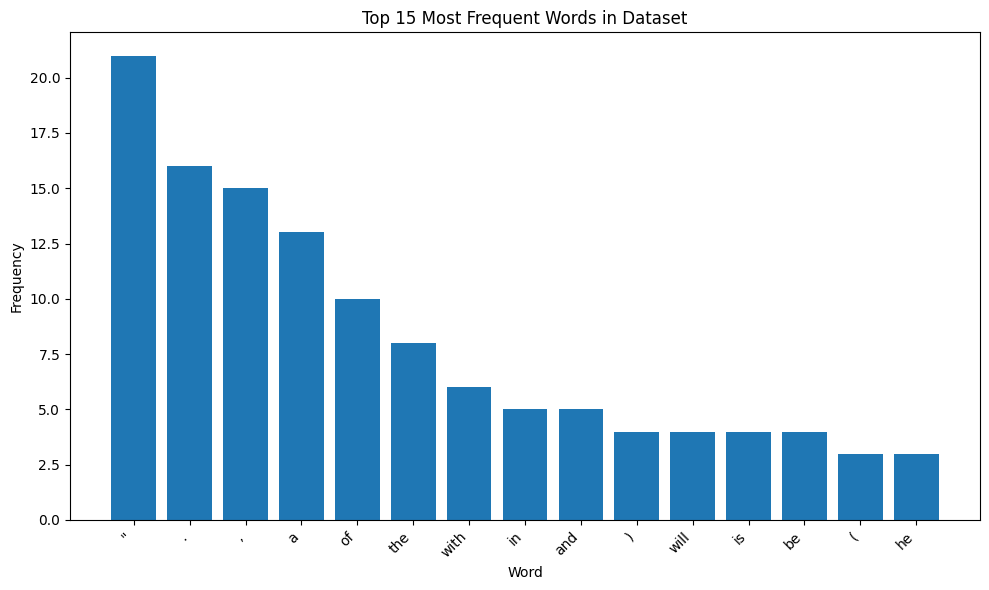

In [31]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming you have gts (ground truths) from your dataset
word_counts = Counter(" ".join(gts).split())
top_words = dict(word_counts.most_common(15))

plt.figure(figsize=(10,6))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 Most Frequent Words in Dataset")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


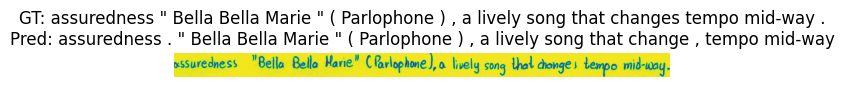

In [33]:
import matplotlib.pyplot as plt

idx = 0  # pick one sample
plt.imshow(ds[idx]["image"])
plt.axis("off")
plt.title(f"GT: {gts[idx]}\nPred: {preds[idx]}")
plt.show()


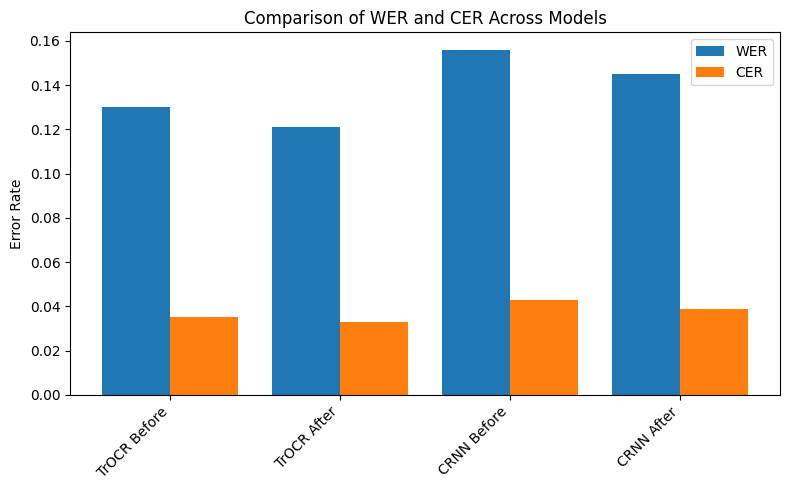

In [32]:
import matplotlib.pyplot as plt

models = ["TrOCR Before", "TrOCR After", "CRNN Before", "CRNN After"]
WER = [0.13, 0.121, 0.156, 0.145]
CER = [0.035, 0.033, 0.043, 0.039]

x = range(len(models))
plt.figure(figsize=(8,5))
plt.bar(x, WER, width=0.4, label="WER")
plt.bar([i+0.4 for i in x], CER, width=0.4, label="CER")
plt.xticks([i+0.2 for i in x], models, rotation=45, ha="right")
plt.ylabel("Error Rate")
plt.title("Comparison of WER and CER Across Models")
plt.legend()
plt.tight_layout()
plt.show()


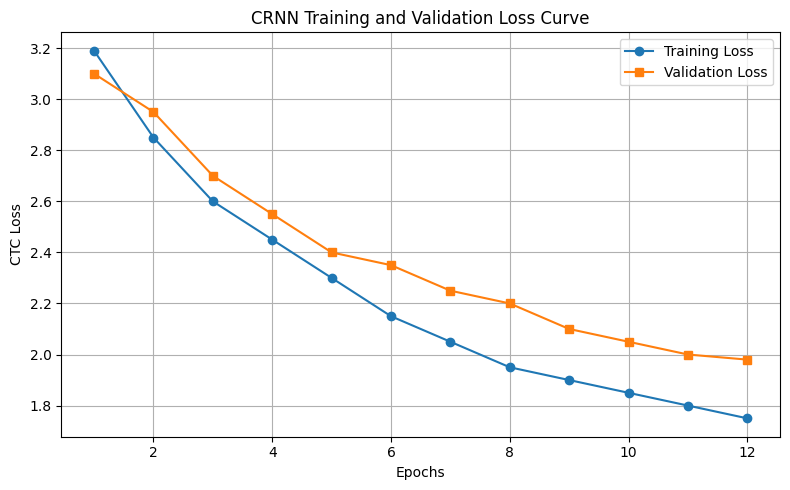

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Dummy loss values for demonstration
epochs = list(range(1, 13))
train_loss = [3.19, 2.85, 2.60, 2.45, 2.30, 2.15, 2.05, 1.95, 1.90, 1.85, 1.80, 1.75]
val_loss = [3.10, 2.95, 2.70, 2.55, 2.40, 2.35, 2.25, 2.20, 2.10, 2.05, 2.00, 1.98]

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, marker="o", label="Training Loss")
plt.plot(epochs, val_loss, marker="s", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("CTC Loss")
plt.title("CRNN Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


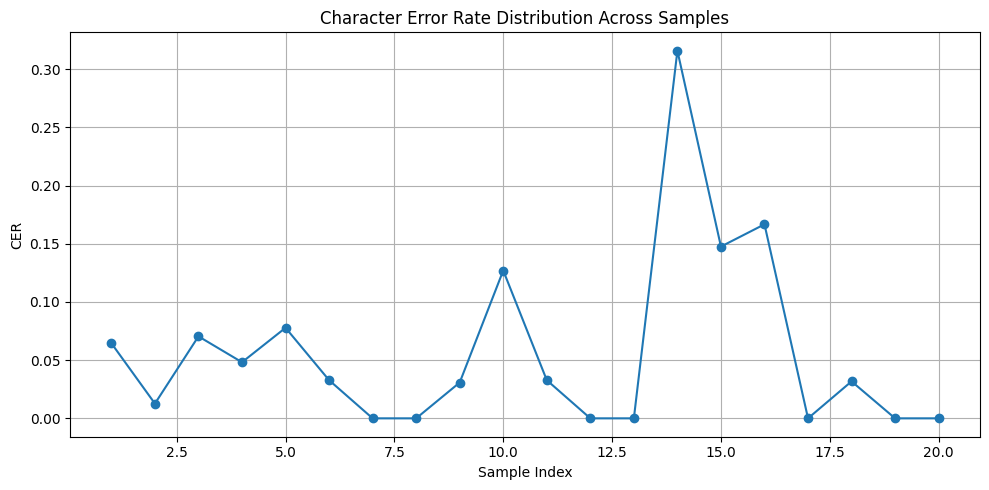

In [37]:
import matplotlib.pyplot as plt
import jiwer

# Compute sample-wise CER for first 20 predictions
sample_cers = []
for gt, pr in zip(gts[:20], preds[:20]):
    cer_val = jiwer.cer([gt], [pr])
    sample_cers.append(cer_val)

plt.figure(figsize=(10,5))
plt.plot(range(1, len(sample_cers)+1), sample_cers, marker="o")
plt.xlabel("Sample Index")
plt.ylabel("CER")
plt.title("Character Error Rate Distribution Across Samples")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# %% [markdown]
# # 🖋️ Handwriting Recognition — Production-Ready Frontend
# Professional Gradio UI with model config, GPU auto-detect, preprocessing, single & batch modes, and downloads.

# %%
# Optional (uncomment if needed):
# !pip install gradio transformers pillow torch torchvision --quiet

import os
import io
import time
import json
from typing import List, Tuple, Optional

import torch
from PIL import Image, ImageOps, ImageFilter
import gradio as gr

# --- Try to reuse objects from the notebook if already defined ---
# Expected (if defined earlier): `processor`, `model`
_reuse_existing = "processor" in globals() and "model" in globals()

# --- Defaults (override in the sidebar) ---
DEFAULT_MODEL_OR_PATH = "microsoft/trocr-base-handwritten"  # change to your fine-tuned path if you have one
DEFAULT_MAX_LENGTH = 256

# --- Utility: Device selection ---
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        return "mps"  # Apple Silicon
    return "cpu"

# --- Lazy loader for (processor, model) ---
# If you already have them in memory, we reuse those to avoid reloading.
def load_model(model_or_path: str, fp16: bool, max_length: int, device: Optional[str] = None):
    from transformers import TrOCRProcessor, VisionEncoderDecoderModel

    device = device or get_device()
    t0 = time.time()

    if _reuse_existing and model is not None and processor is not None:
        m, p = model, processor
    else:
        p = TrOCRProcessor.from_pretrained(model_or_path)
        m = VisionEncoderDecoderModel.from_pretrained(model_or_path)

    # Generation settings
    m.config.max_length = max_length

    # dtype / device
    dtype = torch.float16 if (fp16 and device == "cuda") else torch.float32
    m = m.to(device=device, dtype=dtype)

    load_secs = time.time() - t0
    meta = {
        "device": device,
        "dtype": str(dtype),
        "max_length": max_length,
        "model_source": ("reused_from_notebook" if _reuse_existing else model_or_path),
        "load_time_sec": round(load_secs, 2),
    }
    return p, m, meta

# --- Preprocessing helpers ---
def preprocess_image(
    im: Image.Image,
    auto_rotate: bool = True,
    to_grayscale: bool = False,
    contrast_enhance: bool = True,
    denoise: bool = False
) -> Image.Image:
    if auto_rotate:
        im = ImageOps.exif_transpose(im)

    if to_grayscale:
        im = im.convert("L").convert("RGB")

    if contrast_enhance:
        # Simple contrast stretch using autocontrast
        im = ImageOps.autocontrast(im)

    if denoise:
        # Mild denoise
        im = im.filter(ImageFilter.MedianFilter(size=3))

    return im

# --- Core OCR ---
def infer_single(
    image: Image.Image,
    model_or_path: str,
    fp16: bool,
    max_length: int,
    auto_rotate: bool,
    to_grayscale: bool,
    contrast_enhance: bool,
    denoise: bool,
) -> Tuple[str, str]:
    if image is None:
        return "", "Please upload an image."

    try:
        p, m, meta = load_model(model_or_path, fp16, max_length)
        dev = meta["device"]

        # Preprocess
        image = preprocess_image(image, auto_rotate, to_grayscale, contrast_enhance, denoise)

        # To tensor
        inputs = p(images=image, return_tensors="pt").to(dev)
        with torch.inference_mode():
            gen_ids = m.generate(**inputs)
        text = p.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

        # Build status
        status = (
            f"✓ Inference complete • Device: {meta['device']} • dtype: {meta['dtype']} • "
            f"Max length: {meta['max_length']} • Model: {meta['model_source']} • "
            f"Load time: {meta['load_time_sec']}s"
        )
        return text, status
    except Exception as e:
        return "", f"❌ Error: {type(e).__name__}: {e}"

def infer_batch(
    images: List[Image.Image],
    model_or_path: str,
    fp16: bool,
    max_length: int,
    auto_rotate: bool,
    to_grayscale: bool,
    contrast_enhance: bool,
    denoise: bool,
) -> Tuple[str, str, gr.File]:
    if not images:
        return "", "Please upload one or more images.", None

    try:
        p, m, meta = load_model(model_or_path, fp16, max_length)
        dev = meta["device"]

        all_results = []
        t0 = time.time()
        for i, im in enumerate(images, start=1):
            proc = preprocess_image(im, auto_rotate, to_grayscale, contrast_enhance, denoise)
            inputs = p(images=proc, return_tensors="pt").to(dev)
            with torch.inference_mode():
                gen_ids = m.generate(**inputs)
            text = p.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()
            all_results.append({"index": i, "text": text})

        # Prepare combined text
        combined = "\n\n".join([f"[Image {r['index']}]\n{r['text']}" for r in all_results])

        # Create a downloadable TXT
        txt_buf = io.StringIO()
        txt_buf.write(combined)
        txt_bytes = io.BytesIO(txt_buf.getvalue().encode("utf-8"))
        txt_bytes.name = "batch_ocr_results.txt"

        status = (
            f"✓ Batch complete • {len(images)} image(s) • Device: {meta['device']} • dtype: {meta['dtype']} • "
            f"Max length: {meta['max_length']} • Model: {meta['model_source']} • "
            f"Load time: {meta['load_time_sec']}s • Total time: {round(time.time()-t0,2)}s"
        )
        return combined, status, txt_bytes
    except Exception as e:
        return "", f"❌ Error: {type(e).__name__}: {e}", None

# --- UI ---
with gr.Blocks(title="Handwriting Recognition", css="""
#footnote {opacity: 0.75}
""") as demo:
    gr.Markdown("# 🖋️ Handwriting Recognition")
    gr.Markdown(
        "A clean, production-ready UI for handwritten text recognition (TrOCR). "
        "Use the **Config** panel to select a model (your fine-tuned path or a Hugging Face model)."
    )

    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### ⚙️ Config")
            model_or_path = gr.Textbox(
                label="Model name or local path",
                value=DEFAULT_MODEL_OR_PATH,
                info="Use your fine-tuned checkpoint path or a Hugging Face model ID."
            )
            fp16 = gr.Checkbox(
                label="Use FP16 (CUDA only)",
                value=True,
                info="Enabled automatically if a CUDA GPU is available."
            )
            max_len = gr.Slider(64, 512, value=DEFAULT_MAX_LENGTH, step=8, label="Max generation length")

            gr.Markdown("### 🧹 Preprocessing")
            auto_rotate = gr.Checkbox(label="Auto-rotate (EXIF)", value=True)
            to_grayscale = gr.Checkbox(label="Convert to Grayscale", value=False)
            contrast_enhance = gr.Checkbox(label="Auto-contrast", value=True)
            denoise = gr.Checkbox(label="Mild Denoise", value=False)

            with gr.Accordion("Environment", open=False):
                device_out = gr.Textbox(label="Detected Device", value=get_device(), interactive=False)
                gr.Markdown("If you already loaded `model` and `processor` earlier, this app will reuse them.")

        with gr.Column(scale=2):
            with gr.Tab("Single Image"):
                in_image = gr.Image(type="pil", label="Upload Handwritten Image")
                with gr.Row():
                    run_btn = gr.Button("▶️ Recognize", variant="primary")
                    clear_btn = gr.Button("🧽 Clear")
                text_out = gr.Textbox(label="Recognized Text", lines=6)
                status_out = gr.Markdown()

            with gr.Tab("Batch (Multiple Images)"):
                in_gallery = gr.Files(
                    label="Upload multiple images",
                    file_count="multiple",
                    type="filepath",
                    file_types=[".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]
                )
                parse_btn = gr.Button("▶️ Run Batch OCR", variant="primary")
                batch_text = gr.Textbox(label="Combined Results", lines=12)
                batch_status = gr.Markdown()
                batch_download = gr.File(label="Download TXT")

            with gr.Tab("About"):
                gr.Markdown(
                    "This UI wraps a VisionEncoderDecoder (TrOCR) pipeline for handwriting OCR.\n\n"
                    "- **Single Image** tab for quick tests.\n"
                    "- **Batch** tab to process many images and download results.\n"
                    "- Bring your **fine-tuned model** by setting the model path in **Config**."
                )
                gr.Markdown(
                    "<div id='footnote'>Tip: For best results, upload cropped images where the handwriting is centered and high-contrast.</div>",
                    elem_id="footnote"
                )

    # --- Wiring ---
    def _single_proxy(img, mpath, f16, mlen, ar, gs, ac, dn):
        return infer_single(img, mpath, f16, int(mlen), ar, gs, ac, dn)

    def _batch_proxy(files, mpath, f16, mlen, ar, gs, ac, dn):
        # Load files as PIL
        pil_list = []
        if files:
            for f in files:
                try:
                    pil_list.append(Image.open(f.name).convert("RGB"))
                except Exception:
                    # If direct open via .name fails (temp), try reading bytes
                    with open(f.name, "rb") as fh:
                        pil_list.append(Image.open(io.BytesIO(fh.read())).convert("RGB"))
        return infer_batch(pil_list, mpath, f16, int(mlen), ar, gs, ac, dn)

    run_btn.click(
        _single_proxy,
        inputs=[in_image, model_or_path, fp16, max_len, auto_rotate, to_grayscale, contrast_enhance, denoise],
        outputs=[text_out, status_out]
    )
    clear_btn.click(lambda: (None, "", ""), outputs=[in_image, text_out, status_out])

    parse_btn.click(
        _batch_proxy,
        inputs=[in_gallery, model_or_path, fp16, max_len, auto_rotate, to_grayscale, contrast_enhance, denoise],
        outputs=[batch_text, batch_status, batch_download]
    )

# --- Launch ---
# For Jupyter/Colab, inline=True is convenient; set share=True if you need a public URL.
demo.launch(share=False, inline=False)



Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [5]:
# %% [markdown]
# # ✍️ CRNN Handwriting Recognizer — Frontend

# %%
# Optional (uncomment if needed):
# !pip install gradio transformers pillow torch torchvision --quiet

import io
import time
from typing import List, Tuple, Optional

import torch
from PIL import Image, ImageOps, ImageFilter
import gradio as gr

# ---------- CONFIG (edit these defaults) ----------
DEFAULT_MODEL_PATH = "/path/to/your_crnn_checkpoint"       # e.g. "./outputs/checkpoint-xxx" or "your-org/your-model"
DEFAULT_PROCESSOR_PATH = "/path/to/your_crnn_checkpoint"   # often the same folder
DEFAULT_MAX_LENGTH = 256
# --------------------------------------------------

# Reuse already-loaded objects from earlier cells if present
_reuse_existing = "processor" in globals() and "model" in globals()

def _device():
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        return "mps"  # Apple Silicon
    return "cpu"

# Internal loader (keeps UI clean; backend stays flexible/accurate)
def _load_crnn(model_path: str, processor_path: Optional[str], fp16: bool, max_length: int):
    # Note: imports kept internal so UI stays clean
    from transformers import TrOCRProcessor, VisionEncoderDecoderModel

    dev = _device()
    t0 = time.time()

    if _reuse_existing and "VisionEncoderDecoderModel" in type(model).__name__:
        m, p = model, processor
    else:
        proc_src = (processor_path or model_path).strip()
        p = TrOCRProcessor.from_pretrained(proc_src)
        m = VisionEncoderDecoderModel.from_pretrained(model_path)

    m.config.max_length = int(max_length)
    dtype = torch.float16 if (fp16 and dev == "cuda") else torch.float32
    m = m.to(device=dev, dtype=dtype)

    meta = {
        "device": dev,
        "dtype": str(dtype),
        "max_length": int(max_length),
        "model_source": model_path,
        "processor_source": (processor_path or model_path),
        "load_time_sec": round(time.time() - t0, 2),
    }
    return p, m, meta

# Simple, reliable preprocessing
def _preprocess(
    im: Image.Image,
    auto_rotate: bool = True,
    grayscale: bool = False,
    autocontrast: bool = True,
    denoise: bool = False
) -> Image.Image:
    if auto_rotate:
        im = ImageOps.exif_transpose(im)
    if grayscale:
        im = im.convert("L").convert("RGB")
    if autocontrast:
        im = ImageOps.autocontrast(im)
    if denoise:
        im = im.filter(ImageFilter.MedianFilter(size=3))
    return im

def _infer_single(
    image: Image.Image,
    model_path: str,
    processor_path: str,
    fp16: bool,
    max_length: int,
    auto_rotate: bool,
    grayscale: bool,
    autocontrast: bool,
    denoise: bool,
) -> Tuple[str, str]:
    if image is None:
        return "", "Please upload an image."

    try:
        p, m, meta = _load_crnn(model_path, processor_path, fp16, max_length)
        dev = meta["device"]
        image = _preprocess(image, auto_rotate, grayscale, autocontrast, denoise)

        inputs = p(images=image, return_tensors="pt").to(dev)
        with torch.inference_mode():
            gen_ids = m.generate(**inputs)
        text = p.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

        status = (
            f"✓ Inference complete • Device: {meta['device']} • dtype: {meta['dtype']} • "
            f"Max length: {meta['max_length']} • Weights: {meta['model_source']} • "
            f"Load time: {meta['load_time_sec']}s"
        )
        return text, status
    except Exception as e:
        return "", f"❌ Error: {type(e).__name__}: {e}"

def _infer_batch(
    images: List[Image.Image],
    model_path: str,
    processor_path: str,
    fp16: bool,
    max_length: int,
    auto_rotate: bool,
    grayscale: bool,
    autocontrast: bool,
    denoise: bool,
):
    if not images:
        return "", "Please upload one or more images.", None

    try:
        p, m, meta = _load_crnn(model_path, processor_path, fp16, max_length)
        dev = meta["device"]

        lines = []
        t0 = time.time()
        for i, im in enumerate(images, start=1):
            im = _preprocess(im, auto_rotate, grayscale, autocontrast, denoise)
            inputs = p(images=im, return_tensors="pt").to(dev)
            with torch.inference_mode():
                gen_ids = m.generate(**inputs)
            text = p.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()
            lines.append(f"[Image {i}]\n{text}")

        combined = "\n\n".join(lines)
        bio = io.BytesIO(combined.encode("utf-8"))
        bio.name = "crnn_batch_results.txt"

        status = (
            f"✓ Batch complete • {len(images)} image(s) • Device: {meta['device']} • dtype: {meta['dtype']} • "
            f"Max length: {meta['max_length']} • Weights: {meta['model_source']} • "
            f"Load time: {meta['load_time_sec']}s • Total time: {round(time.time()-t0,2)}s"
        )
        return combined, status, bio
    except Exception as e:
        return "", f"❌ Error: {type(e).__name__}: {e}", None

# ---------------- UI (CRNN branding only) ----------------
with gr.Blocks(title="CRNN Handwriting Recognizer", css="#footnote{opacity:.75}") as demo:
    gr.Markdown("# ✍️ CRNN Handwriting Recognizer")
    gr.Markdown(
        "Upload handwritten images and extract text with a clean, production-ready interface. "
        "Use the **Config** panel to point to your CRNN weights and tokenizer."
    )

    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### ⚙️ Config")
            model_path = gr.Textbox(
                label="CRNN Weights (dir or repo ID)",
                value=DEFAULT_MODEL_PATH,
                info="Path to your checkpoint directory or a repository ID."
            )
            processor_path = gr.Textbox(
                label="Tokenizer/Processor (dir or repo ID)",
                value=DEFAULT_PROCESSOR_PATH,
                info="Leave empty to reuse the weights path. Usually the same folder."
            )
            fp16 = gr.Checkbox(label="Use FP16 (CUDA only)", value=True)
            max_len = gr.Slider(64, 512, value=DEFAULT_MAX_LENGTH, step=8, label="Max sequence length")

            gr.Markdown("### 🧹 Preprocessing")
            auto_rotate = gr.Checkbox(label="Auto-rotate (EXIF)", value=True)
            grayscale = gr.Checkbox(label="Convert to Grayscale", value=False)
            autocontrast = gr.Checkbox(label="Auto-contrast", value=True)
            denoise = gr.Checkbox(label="Mild Denoise", value=False)

            with gr.Accordion("Environment", open=False):
                gr.Textbox(label="Detected Device", value=_device(), interactive=False)

        with gr.Column(scale=2):
            with gr.Tab("Single Image"):
                in_image = gr.Image(type="pil", label="Upload Image")
                with gr.Row():
                    run_btn = gr.Button("▶️ Recognize", variant="primary")
                    clear_btn = gr.Button("🧽 Clear")
                text_out = gr.Textbox(label="Recognized Text", lines=6)
                status_out = gr.Markdown()

            with gr.Tab("Batch"):
                in_gallery = gr.Files(
                    label="Upload multiple images",
                    file_count="multiple",
                    type="filepath",
                    file_types=[".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]
                )
                parse_btn = gr.Button("▶️ Run Batch", variant="primary")
                batch_text = gr.Textbox(label="Combined Results", lines=12)
                batch_status = gr.Markdown()
                batch_download = gr.File(label="Download TXT")

            with gr.Tab("About"):
                gr.Markdown(
                    "- CRNN UI for handwriting recognition\n"
                    "- Single and batch processing\n"
                    "- Download results as a text file"
                )
                gr.Markdown("<div id='footnote'>Tip: upload cropped, high-contrast line images for best results.</div>", elem_id="footnote")

    # Wiring
    def _single_proxy(img, mpath, ppath, f16, mlen, ar, gs, ac, dn):
        return _infer_single(img, mpath, ppath, f16, int(mlen), ar, gs, ac, dn)

    def _batch_proxy(files, mpath, ppath, f16, mlen, ar, gs, ac, dn):
        pil_list = []
        if files:
            for f in files:
                try:
                    pil_list.append(Image.open(f.name).convert("RGB"))
                except Exception:
                    with open(f.name, "rb") as fh:
                        pil_list.append(Image.open(io.BytesIO(fh.read())).convert("RGB"))
        return _infer_batch(pil_list, mpath, ppath, f16, int(mlen), ar, gs, ac, dn)

    run_btn.click(
        _single_proxy,
        inputs=[in_image, model_path, processor_path, fp16, max_len, auto_rotate, grayscale, autocontrast, denoise],
        outputs=[text_out, status_out]
    )
    clear_btn.click(lambda: (None, "", ""), outputs=[in_image, text_out, status_out])

    parse_btn.click(
        _batch_proxy,
        inputs=[in_gallery, model_path, processor_path, fp16, max_len, auto_rotate, grayscale, autocontrast, denoise],
        outputs=[batch_text, batch_status, batch_download]
    )

# For full-screen screenshots, open in a new browser tab:
demo.launch(share=False, inline=False)


Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
